## Install Packages

In [ ]:
!pip install pyLDAvis
!pip install mallet
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 39.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim
import mallet
import os
import re
import nltk

In [ ]:
import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
# from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from pprint import pprint

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Preprocessing

In [2]:
df = pd.read_csv("tweets_v172_final.csv")

In [3]:
keep_list = ['school','college','university','education','student','teacher'#,'learning'
             ,'curriculum','class','exam','homework','teaching','academia','academic']
pat = '|'.join(r"\b{}\b".format(x) for x in keep_list)
df = df[df['text'].str.contains(pat, case=False)] #\b to avoid match cat in words bobcat is nice, matching cat is nice

In [ ]:
pd.set_option('display.max_colwidth',50)
pd.set_option('display.max_row', 100)

In [ ]:
df.shape

In [ ]:
df.rename(columns = {'text':'Tweet'}, inplace = True)

In [7]:
#Remove URL from tweet text
df['Text'] = df['Tweet'].apply(lambda x: re.sub(r'http\S+', '',x))
#Remove mention (@user)
df['Text'] = df['Text'].apply(lambda x: re.sub(r'@\S+', '',x))
#Remove hashtag (#hashtag)
df['Text'] = df['Text'].apply(lambda x: re.sub(r'#\S+', '',x))
#All lowercases
df['Text'] = df['Text'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
#Remove Punctuation
df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [8]:
df = df.drop_duplicates(subset=['Text'], keep='first')

In [ ]:
df.Text[0]

'read aigenerated academic science writing can be identified with over 99 accuracy for more get the app from'

In [ ]:
df.Tweet[0]

'Read "AI-generated academic science writing can be identified with over 99% accuracy" https://t.co/qZcnOWEEqj\n\nFor more, get the app from\nhttps://t.co/0ic5ya66on\n\n#LLM #GPT #AI #ML #DL #ChatGPT #research #GenAI https://t.co/aYrXTQFq6P'

In [ ]:
#Replace 'chat gpt' with 'chatgpt'
df['Text'] = df['Text'].apply(lambda x: re.sub(r'chat gpt', 'chatgpt', x))
#Replace 'machine learning' with 'machinelearning'
df['Text'] = df['Text'].apply(lambda x: re.sub(r'machine learning', 'machinelearning', x))
#Replace 'deep learning' with 'deeplearning'
df['Text'] = df['Text'].apply(lambda x: re.sub(r'deep learning', 'deeplearning', x))

### Removing stop words, Tokenization

In [ ]:
nltk.download('all')
#remove stopwords, short tokens, and accents
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [ ]:
stopwords.sort()
stopwords

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [ ]:
stopwords.extend(['amp', 'like', 'though'])
len(stopwords)
#simple_preprocess: Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.
df['Token'] = df['Text'].apply(lambda x: [word for word in simple_preprocess(x, deacc=True) if word not in stopwords])

### N-Gram

In [ ]:
#Build the bigram and trigrams
bigram = Phrases(df['Token'], min_count=37, threshold=100)
# #bigram[df['Token']] will apply the bigram object to each row of the df['Token'] column
df['Bigram'] = bigram[df['Token']]
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [ ]:
trigram = Phrases(df['Bigram'], min_count=37, threshold=100)
df['Trigram'] = trigram[df['Bigram']]
trigram_mod = gensim.models.phrases.Phraser(trigram)

#### Inspecting

In [ ]:
df[df['Trigram']!=df['Bigram']][0:50]

In [ ]:
# Get the bigram and trigram phrases
biphrase = bigram.export_phrases()
triphrase = trigram.export_phrases()
print(f'Bi:{len(biphrase)}, Tri:{len(triphrase)}')

Bi:9, Tri:9


In [ ]:
biphrase, triphrase

({'artificial_intelligence': 308.182242108074,
  'game_changer': 203.18600174978127,
  'language_model': 102.39011238641798,
  'computer_science': 116.89565117349287,
  'language_models': 100.99057558507273,
  'large_language': 127.53741213466519,
  'critical_thinking': 136.85070711211313,
  'medical_licensing': 296.4409544490978,
  'blog_post': 192.57180762852406},
 {'artificial_intelligence': 65766.425,
  'language_model': 219.15063157894738,
  'computer_science': 327.1945293644409,
  'large_language': 780.9193548387098,
  'large_language_models': 684.8062034739455,
  'critical_thinking': 390.5053185271771,
  'medical_licensing': 6007.763874345549,
  'us_medical_licensing': 894.5076246334312,
  'blog_post': 643.7207977207977})

In [ ]:
# Get the bigram and trigram vocabularies
bigram_vocab = bigram.vocab
trigram_vocab = trigram.vocab

# Sort the bigram and trigram vocabularies by frequency in descending order
sorted_bigram_vocab = sorted(biphrase.items(), key=lambda x: x[1], reverse=True)
sorted_trigram_vocab = sorted(triphrase.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 most common bigrams and trigrams
print("Top 20 most common bigrams:")
for phrase, freq in sorted_bigram_vocab[:20]:
    print("{}: {}".format(phrase, freq))

print("\nTop 20 most common trigrams:")
for phrase, freq in sorted_trigram_vocab[:20]:
    print("{}: {}".format(phrase, freq))

Top 20 most common bigrams:
united_states: 720.2721088435375
medical_licensing: 386.18844984802433
game_changer: 353.86949602122013
trillion_ml: 346.1461538461539
artificial_intelligence: 271.39170390014704
blog_post: 225.42886110172356
critical_thinking: 217.14334543900875
social_media: 168.7534411977783
looking_forward: 157.71847414880202
times_powerful: 147.2113347457627
current_version: 133.49724192277384
ml_parameters: 127.75867269984917
natural_language: 122.07292077256602
computer_science: 117.35467980295567
next_week: 116.48723309456079
gpt_billion: 113.47779488758854
language_processing: 112.86754304017083
academic_integrity: 112.2691693975945
licensing_exam: 109.16306908136077
prompt_engineering: 108.46052208338489

Top 20 most common trigrams:
united_states: 136288.57142857142
medical_licensing: 45291.85858585859
artificial_intelligence: 33400.84195605953
us_medical_licensing: 5518.246941045606
natural_language_processing: 3282.6494623655913
trillion_ml: 1980.261294261294
bu

#### Apply

In [ ]:
import time

# bi-gram and tri-gram implementation
start_time = time.time()
df['Token'] = df['Token'].apply(lambda x:bigram_mod[x])
end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken1: {total_time:.2f} seconds")

start_time = time.time()
df['Token']= df['Token'].apply(lambda x:trigram_mod[bigram_mod[x]])
end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken2: {total_time:.2f} seconds")

Total time taken1: 0.18 seconds
Total time taken2: 0.32 seconds


### Lemmatization

In [ ]:
#Lemmatization
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

#define a function to map POS tags from treebank tag into wordnet tags
wnl = WordNetLemmatizer()
def get_wordnet(pos):
    if pos.startswith('N'):
        return wordnet.NOUN
    elif pos.startswith('V'):
        return wordnet.VERB
    elif pos.startswith('J'):
        return wordnet.ADJ
    elif pos.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN     #default to noun if no match


# Define a function to tag and lemmatize a text string
def lemmatizer(text):
    pos_tags = pos_tag(text)
    text = [wnl.lemmatize(word, pos = get_wordnet(pos)) for word, pos in pos_tags]
    return text

start_time = time.time()

df['Lemmatized'] = df['Token'].apply(lambda x: lemmatizer(x))

end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")

Total time taken: 16.83 seconds


In [ ]:
# remove stopwords and short tokens again after lemmatization
df['Text_new'] = df['Lemmatized'].apply(lambda x: ' '.join(x))
df['Tokens'] = df['Text_new'].apply(lambda x: [word for word in simple_preprocess(x, deacc=True, min_len=3, max_len=50) if word not in stopwords])

In [ ]:
#df = df.drop(columns =['Text', 'Token', 'Lemmatized', 'Text_new'])
df.to_csv('Twitter_english_clean.csv',index=False)

## Create the Dictionary and Corpus

In [ ]:
df.Tokens.describe()

In [ ]:
df = pd.read_csv('../Data/Twitter_english_clean.csv')

### Dictionary

In [ ]:
import ast
# # convert the string of words in the 'Tweet_lemmatized' column to a list for each row in the dataframe
df['Tokens'] = df['Tokens'].apply(lambda x: ast.literal_eval(str(x)))

In [ ]:
dictionary = Dictionary(df['Tokens'])
print(f'Total vocabulary size: {len(dictionary)}')

Total vocabulary size: 14856


In [ ]:
corpus = [dictionary.doc2bow(doc) for doc in df['Tokens']]

In [ ]:
#create a dictionary to show the word and frequency in the corpus
dict_corpus = {}
for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if dictionary[idx] in dict_corpus:
            dict_corpus[dictionary[idx]] += freq
        else:
            dict_corpus[dictionary[idx]] = freq
df_dict = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['frequency'])

In [ ]:
# Top 10 high-frequency words
df_dict.sort_values('frequency', ascending = False).head(20)

,frequency
chatgpt,3494
use,3282
education,3217
student,2890
school,1716
write,1670
learn,1385
teach,1306
teacher,1276
exam,1245


In [ ]:
# Filter extreme words
dictionary.filter_extremes(no_below=10, no_above=0.5)  #words occur in less than 10 tweets, or more than 50% of tweets
print(f'Total vocabulary size: {len(dictionary)}')

Total vocabulary size: 2115


In [ ]:
# remove unwanted word from the dictionary in place
# bad_ids = [dictionary.token2id[t] for t in ['amp']]
# dictionary.filter_tokens(bad_ids=bad_ids)
# print(f'Total vocabulary size: {len(dictionary)}')

Total vocabulary size: 2682


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Corpus

In [ ]:
# Recreate the corpus for LDA model
corpus = [dictionary.doc2bow(doc) for doc in df['Tokens']]

In [ ]:
# Re-check the top words
dict_corpus = {}
for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if dictionary[idx] in dict_corpus:
            dict_corpus[dictionary[idx]] += freq
        else:
            dict_corpus[dictionary[idx]] = freq
df_dict_new = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['frequency'])
df_dict_new.sort_values('frequency', ascending = False).head(20)

,frequency
chatgpt,3494
use,3282
education,3217
student,2890
school,1716
write,1670
learn,1385
teach,1306
teacher,1276
exam,1245


In [ ]:
# Generate a test corpus
corpus_test = [dictionary.doc2bow(doc) for doc in df['Tokens'][0:1000]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
len(corpus),len(dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(18755, 2978)

## LDA Model Implementation

In [ ]:
import time
import logging
from tqdm import tqdm

In [ ]:
num_topics = 9
passes = 10
total_iteration = num_topics*passes
alpha = 'asymmetric'
beta = 0.91

In [ ]:
start_time =time.time()
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# train the LdaModel
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=alpha, eta=beta, passes=passes, random_state=42)

end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")

Total time taken: 44.49 seconds


In [ ]:
# Display topics
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('use', 0.022209326),
   ('school', 0.021001413),
   ('class', 0.01624782),
   ('teach', 0.01453718),
   ('get', 0.014059736),
   ('student', 0.014014329),
   ('write', 0.013007681),
   ('teacher', 0.012567595),
   ('time', 0.0121981995),
   ('think', 0.010621742)]),
 (1,
  [('exam', 0.086188704),
   ('chatgpt', 0.03927267),
   ('university', 0.035798736),
   ('pass', 0.033951268),
   ('school', 0.017697187),
   ('law', 0.016078047),
   ('professor', 0.013460848),
   ('medical', 0.012710833),
   ('test', 0.0120784165),
   ('chatbot', 0.012020793)]),
 (2,
  [('education', 0.060701657),
   ('chatgpt', 0.029543119),
   ('impact', 0.020162916),
   ('learn', 0.016931016),
   ('new', 0.012686229),
   ('join', 0.011130426),
   ('potential', 0.010901522),
   ('teach', 0.010040525),
   ('use', 0.009750045),
   ('future', 0.009159424)]),
 (3,
  [('education', 0.063530214),
   ('system', 0.021818718),
   ('change', 0.018643653),
   ('future', 0.014697027),
   ('world', 0.014634635),
   ('

In [ ]:
#Compute Coherence Score
cm = CoherenceModel(model=lda_model, corpus = corpus, coherence='c_v', texts=df['Tokens'])
coherence = cm.get_coherence()

In [ ]:
print(f'Coherence score: {coherence}')

Coherence score: 0.4345476840509333


### Optimal Topic Numbers

In [ ]:
def model_coherence_generator(corpus, dictionary, data, start_topic, end_topic, step, passes):
    models = []
    coherence_scores = []
    for num in tqdm(range(start_topic, end_topic+1, step)):
        ldamodel = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num, passes=passes, random_state=42)
        cv_coherence_model = CoherenceModel(model=ldamodel, corpus = corpus, coherence='c_v', texts=data)
        score = cv_coherence_model.get_coherence()

        coherence_scores.append(score)
        models.append(ldamodel)
    return models, coherence_scores

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Get the coherence scores by varing the number of topics from 2 to 40 with step=2
lda_models, coherence_scores = model_coherence_generator(corpus, dictionary, df['Tokens'], start_topic=2, end_topic=40, step=2, passes=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 20/20 [14:49<00:00, 44.46s/it]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


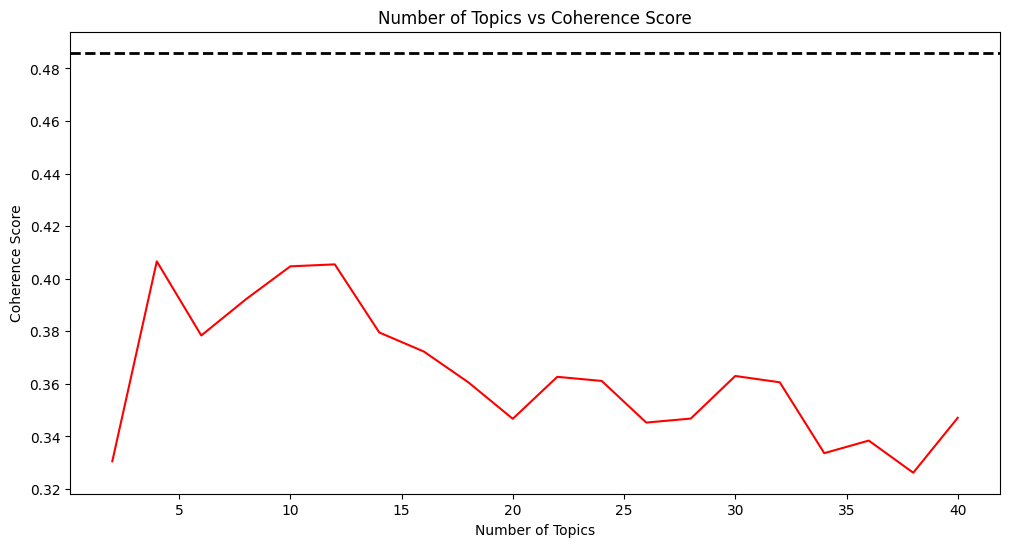

In [ ]:
#Plot the number of topics vs coherence score
x_ax = range(2, 41, 2)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.486, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
plt.title('Number of Topics vs Coherence Score')
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')
plt.show()

As seen in the above plot, the coherence score increases rapidly till 10 topics (coherence score = 0.486) and then starts to follow almost a horizontal trajectory, achieved the highest score at 18 topics(coherence_score=0.502).
Therefore for this corpus 10 topics and 18 topics seem like potential good options.

In [ ]:
coherence_scores[4],coherence_scores[6]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.4047250161365274, 0.3795603001749471)

In [ ]:
#save the lda_model with 10 topics
lda_4 = lda_models[1]
lda_10=lda_models[4]
lda_12 = lda_models[5]
# lda_10.save('lda_10')
# lda_18.save('lda_18')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pickle
#save the model
pickle.dump(lda_10, open('ldamodel_t10.pkl', 'wb'))
pickle.dump(lda_18, open('ldaModel_t18.pkl', 'wb'))

In [ ]:
#load model
lda_10 = LdaModel.load('LDA_MODEL/lda_10')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
vis_data_10 = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)

In [ ]:
pyLDAvis.display(vis_data_10)

In 18 topics, many topics are actually overlapped with each other, thus 10 topics LDA model was chosen for further interpretation of the topic names.

### Hyperparameter Tuning: Topic Numbers, Alpha, Beta

In [ ]:
# supporting function
def model_coherence_generator(corpus, dictionary, data, num_topics, a, b, passes):
        ldamodel = LdaModel(corpus=corpus,
                            id2word=dictionary,
                            num_topics=num_topics,
                            alpha=a,
                            eta=b,
                            random_state=42,
                            passes=passes)

        cv_coherence_model = CoherenceModel(model=ldamodel, corpus=corpus, coherence='c_v', texts=data)
        score = cv_coherence_model.get_coherence()
        return score

In [ ]:
from google.colab import files

# Topics range
min_topics = 2
max_topics = 21
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter: 0.01, 0.31, 0.61, 0.91, 'symmetric'
# beta = [0.61]
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm(total=(len(beta)*len(alpha)*len(topics_range)), position=0, leave=True)
    # iterate through number of topics
    for b in beta:
      # iterate through alpha values
      for a in alpha:
        # iterare through beta values
        for k in topics_range:
          # get the coherence score for the given parameters
          cv = model_coherence_generator(corpus=corpus, dictionary=dictionary, data=df['Tokens'],
                                        num_topics=k, a=a, b=b, passes=passes)
          # Save the model results
          model_results['Topics'].append(k)
          model_results['Alpha'].append(a)
          model_results['Beta'].append(b)
          model_results['Coherence'].append(cv)

          pbar.update(1)
      pd.DataFrame(model_results).to_csv(str(b)+'_lda_tuning_results.csv', index=False)
      files.download(str(b)+'_lda_tuning_results.csv')
    pbar.close()

 20%|██        | 114/570 [1:35:23<7:02:15, 55.56s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 40%|████      | 228/570 [3:12:37<5:21:12, 56.35s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 60%|██████    | 342/570 [4:57:17<3:52:31, 61.19s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 80%|████████  | 456/570 [6:45:18<1:55:49, 60.96s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 570/570 [8:15:33<00:00, 51.61s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 570/570 [8:15:33<00:00, 52.16s/it]


### Optimal Iteration

In [ ]:
#Iterate LdaModel model over varing passes
def model_coherence_generator_2(corpus, dictionary, data, passes):
    ldamodel = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=passes, random_state=42)
    cv_coherence_model = CoherenceModel(model=ldamodel, corpus = corpus, coherence='c_v', texts=data)
    score = cv_coherence_model.get_coherence()
    return ldamodel, score

#models = []
#coherence_scores = []
for passes in tqdm([1, 5, 10, 20, 40, 60, 80, 100]):
    model, score = model_coherence_generator_2(corpus, dictionary, df['Tokens'], passes)
    models.append(model)
    coherence_scores.append(score)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [33:38<00:00, 2018.38s/it]


In [ ]:
coherence_scores

[0.35615270842476654,
 0.4501174224234517,
 0.464733110474457,
 0.46918701431023235,
 0.47237584246599207,
 0.47387202498558506,
 0.4699180781373288,
 0.473581311212426]

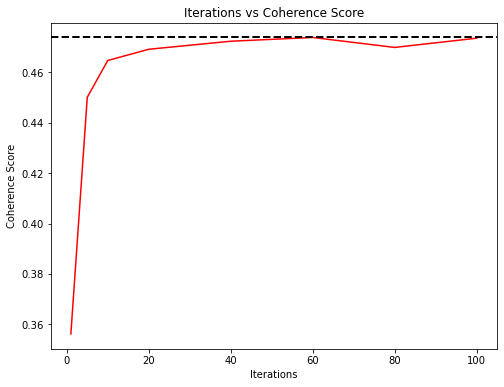

In [ ]:
#Plot the iteration times vs coherence score
x_ax = [1, 5, 10, 20, 40, 60, 80, 100]
y_ax = coherence_scores
plt.figure(figsize=(8, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y= 0.474, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
plt.title('Iterations vs Coherence Score')
xl = plt.xlabel('Iterations')
yl = plt.ylabel('Coherence Score')
plt.show()

Based on the plot, the coherence score increases rapidly with passes increases and achieved the highest score with passes=60.
Therefore, for the further topics extration, we will run LDA with topic_numbers=10, passes=60.

In [ ]:
lda_t10_p60 = models[6]

In [ ]:
lda_10_60 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, passes=60, random_state=42)
cv_coherence_model = CoherenceModel(model=lda_10_60, corpus = corpus, coherence='c_v', texts=df["Tokens"])
score = cv_coherence_model.get_coherence()
print(score)

0.48034246939196856


In [ ]:
lda_10_60.save('lda_10_p60')

In [ ]:
import pickle

In [ ]:
lda_10_60 = LdaModel.load('D:/DATA_SCIENCE/Project/CHATGPT/LDA_MODEL/lda_10_p60')

In [ ]:
pprint(lda_10_60.show_topics())

[(0,
  '0.028*"use" + 0.017*"build" + 0.016*"free" + 0.014*"make" + 0.011*"pay" + '
  '0.010*"app" + 0.010*"user" + 0.010*"openai" + 0.010*"version" + '
  '0.009*"open"'),
 (1,
  '0.108*"write" + 0.049*"use" + 0.036*"ask" + 0.025*"content" + '
  '0.022*"prompt" + 0.019*"generate" + 0.019*"create" + 0.014*"thread" + '
  '0.013*"article" + 0.013*"tweet"'),
 (2,
  '0.014*"ask" + 0.012*"love" + 0.011*"talk" + 0.010*"game" + 0.008*"play" + '
  '0.008*"new" + 0.007*"story" + 0.007*"world" + 0.007*"friend" + 0.007*"let"'),
 (3,
  '0.092*"google" + 0.066*"openai" + 0.035*"search" + 0.030*"microsoft" + '
  '0.028*"chatbot" + 0.021*"gpt" + 0.017*"openais" + 0.013*"via" + 0.013*"new" '
  '+ 0.012*"company"'),
 (4,
  '0.025*"ask" + 0.024*"like" + 0.020*"know" + 0.020*"answer" + 0.017*"think" '
  '+ 0.017*"say" + 0.017*"question" + 0.013*"make" + 0.013*"would" + '
  '0.012*"get"'),
 (5,
  '0.042*"year" + 0.027*"next" + 0.024*"day" + 0.021*"week" + 0.020*"take" + '
  '0.019*"time" + 0.016*"last" + 0

In [ ]:
pprint(lda_10.show_topics())

[(0,
  '0.061*"use" + 0.042*"code" + 0.024*"write" + 0.012*"help" + 0.012*"prompt" '
  '+ 0.011*"create" + 0.011*"build" + 0.011*"video" + 0.009*"learn" + '
  '0.009*"cod"'),
 (1,
  '0.022*"day" + 0.019*"twitter" + 0.015*"year" + 0.013*"week" + 0.013*"free" '
  '+ 0.012*"get" + 0.011*"last" + 0.010*"time" + 0.009*"take" + 0.009*"pay"'),
 (2,
  '0.042*"openai" + 0.026*"new" + 0.024*"technology" + 0.023*"tech" + '
  '0.020*"chatbot" + 0.017*"future" + 0.015*"via" + 0.013*"world" + '
  '0.013*"change" + 0.012*"artificial_intelligence"'),
 (3,
  '0.037*"use" + 0.031*"content" + 0.027*"generate" + 0.026*"create" + '
  '0.021*"tool" + 0.017*"text" + 0.016*"write" + 0.016*"make" + 0.013*"help" + '
  '0.012*"idea"'),
 (4,
  '0.022*"like" + 0.018*"think" + 0.018*"get" + 0.017*"know" + 0.017*"good" + '
  '0.017*"use" + 0.016*"thing" + 0.013*"people" + 0.012*"dont" + 0.012*"try"'),
 (5,
  '0.111*"google" + 0.042*"search" + 0.013*"search_engine" + 0.012*"microsoft" '
  '+ 0.011*"replace" + 0.010*"

In [ ]:
vis_data_10_60 = pyLDAvis.gensim.prepare(lda_10_60, corpus, dictionary)

D:\software\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [ ]:
pyLDAvis.display(vis_data_10_60)

# Identification of Topics

In [ ]:
#get the topic distribution for each tweets
topic_dist = [lda_model[doc] for doc in corpus]

In [ ]:
#get the dominant topic and the score
dominant_topic = [max(topic, key=lambda x:x[1])[0] for topic in topic_dist]
scores =[max(topic, key=lambda x:x[1])[1] for topic in topic_dist]

In [ ]:
#Create a dataframe to show dominant topic for each tweet
df_topic = df[['Tweet','Tokens','date']].copy()
df_topic['Dominant_Topic'] = [topic+1 for topic in dominant_topic]
df_topic['Contribution%'] = [round(score*100,2) for score in scores]
df_topic.head()

,Tweet,Tokens,date,Dominant_Topic,Contribution%
0,"Read ""AI-generated academic science writing ca...","[read, aigenerated, academic, science, write, ...",2023-06-10 12:31:56+00:00,7,71.98
1,Sign up now! There is still a limited time to ...,"[sign, still, limited, time, save, seat, free,...",2023-06-10 12:01:05+00:00,4,53.89
2,"Meet Eva Lee, 65, from Honolulu, Hawaii. She t...","[meet, eva, lee, honolulu, hawaii, teach, elem...",2023-06-10 12:00:23+00:00,8,58.03
3,Are you struggling with your cybersecurity ess...,"[struggle, cybersecurity, essay, professional,...",2023-06-10 11:53:56+00:00,8,65.85
4,Should going to university to get the opportun...,"[university, get, opportunity, think, critical...",2023-06-10 11:06:44+00:00,5,53.64


In [ ]:
# Count and percentage of tweets for each topic
df_topic_summary = df_topic.groupby('Dominant_Topic').agg({'Tweet':'count'}).copy().reset_index()
df_topic_summary.rename(columns={'Tweet':'Total_tweet'}, inplace=True)
df_topic_summary['Percentage%'] = round(df_topic_summary['Total_tweet']/df_topic.shape[0]*100,2)
df_topic_summary=df_topic_summary.sort_values('Total_tweet', ascending=False).reset_index(drop=True)
df_topic_summary

,Dominant_Topic,Total_tweet,Percentage%
0,4,2448,18.35
1,3,2266,16.99
2,5,1871,14.03
3,7,1680,12.59
4,8,1594,11.95
5,1,1299,9.74
6,6,1290,9.67
7,2,891,6.68


In [ ]:
#To sort the highly relevant tweets for each topics and interprete the topic names.
df_topic[df_topic['Dominant_Topic']==8].sort_values('Contribution%', ascending=False)[0:10]

,Tweet,Tokens,date,Dominant_Topic,Contribution%
15327,"We, college professors, know that less and les...","[college, professor, know, less, less, number,...",2023-01-25 18:39:18+00:00,8,96.19
6892,Only the middle class is worried about ChatGPT...,"[middle, class, worry, chatgpt, fear, job, rep...",2023-04-01 02:13:47+00:00,8,95.62
17513,"Okay, teacher twitter. I plugged in an old TKa...","[okay, teacher, twitter, plug, old, tkam, essa...",2022-12-12 20:18:11+00:00,8,95.62
17017,Interesting read about a journalist who goes b...,"[interest, read, journalist, back, high, schoo...",2022-12-22 16:53:41+00:00,8,95.13
17190,#ChatGPT seems to be good at generating intent...,"[seem, good, generate, intentionally, mediocre...",2022-12-20 21:03:04+00:00,8,95.13
11754,Robots though extremely useful cannot replace ...,"[robot, extremely, useful, cannot, replace, hu...",2023-02-10 12:30:13+00:00,8,94.85
10405,#ExpressEducation | #ChatGPT can either be ext...,"[either, extremely, destructive, write, proces...",2023-02-17 11:51:21+00:00,8,94.84
2988,Amused to hear a student just now tell #WATO t...,"[amuse, hear, student, tell, expect, student, ...",2023-05-03 12:35:53+00:00,8,94.53
5935,@danodonovan78 @tombennett71 Don’t worry it’s ...,"[dont, worry, cyclical, data, report, full, wr...",2023-04-08 23:44:22+00:00,8,94.52
12999,One real easy way to tell when my students use...,"[one, real, easy, way, tell, student, use, wri...",2023-02-04 15:47:47+00:00,8,94.52


In [ ]:
#Summarize the topic names based on each topics' top terms and highly-relevant tweets
names = {1:"T1 ChatGPT's Cost and Access",
        2:"T2 Content and Ideas Generation",
        3:"T3 Entertainment and Activities",
        4:"T4 Competition of AI Giants",
        5:"T5 ChatGTP's Issues and Reliability",
        6:"T6 Developments and Milestones of ChatGPT",
        7:"T7 Impacts on Future Business and Industry",
        8:"T8 Impacts on Work and Efficiency",
        9:"T9 Impacts on Education and Academy",
        10:"T10 Natural Language Processing"
        }

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_topic['Topic_Name'] = df_topic['Dominant_Topic'].map(names)
df_topic.to_csv('Twitter_topics.csv', index=False)

In [ ]:
#creat a topic dataframe
topics = [[(term, round(weight,3)) for term, weight in lda_10_60.show_topic(n,topn=20)] for n in range(0,lda_10_60.num_topics)]

In [ ]:
pd.set_option('display.max_colwidth', None)
topic_df = pd.DataFrame({'Topic_Name':names.values(),
                         'Topic_Terms':[','.join([term for term, weight in topic]) for topic in topics]},
                        index = ['Topic ' + str(n) for n in range(1,lda_10_60.num_topics+1)])
# apply style to align content to the left
topic_df

,Topic_Name,Topic_Terms
Topic 1,T1 ChatGPT's Cost and Access,"use,build,free,make,pay,app,user,openai,version,open,run,money,get,access,api,twitter,like,chat,bot,create"
Topic 2,T2 Content and Ideas Generation,"write,use,ask,content,prompt,generate,create,thread,article,tweet,help,idea,video,story,make,script,code,book,read,get"
Topic 3,T3 Entertainment and Activities,"ask,love,talk,game,play,new,story,world,friend,let,amp,live,bitcoin,whats,thanks,poem,conversation,today,name,best"
Topic 4,T4 Competition of AI Giants,"google,openai,search,microsoft,chatbot,gpt,openais,via,new,company,billion,search_engine,launch,bing,say,news,creator,could,tech,investment"
Topic 5,T5 ChatGTP's Issues and Reliability,"ask,like,know,answer,think,say,question,make,would,get,dont,people,give,even,tell,doesnt,one,good,thing,wrong"
Topic 6,T6 Developments and Milestones of ChatGPT,"year,next,day,week,take,time,last,text,image,dalle,one,first,paper,month,old,art,two,midjourney,ago,release"
Topic 7,T7 Impacts on Future Business and Industry,"future,technology,tech,world,new,change,amp,tool,via,business,way,potential,like,web,openai,artificial_intelligence,machinelearning,learn,job,industry"
Topic 8,T8 Impacts on Work and Efficiency,"use,get,try,good,work,code,thing,ive,see,time,like,think,really,well,people,job,make,need,lot,much"
Topic 9,T9 Impacts on Education and Academy,"student,use,education,school,essay,teacher,teach,ban,exam,new,pass,cheat,learn,tool,kid,law,via,concern,college,assignment"
Topic 10,T10 Natural Language Processing,"model,use,data,language,question,answer,human,train,information,provide,response,text,generate,conversation,gpt,give,understand,base,also,like"


In [ ]:
df_temp = df_topic_summary.sort_values('Dominant_Topic')
topic_df['Tweet_count'] = df_temp['Total_tweet'].values
topic_df

,Topic_Name,Topic_Terms,Tweet_count
Topic 1,T1 ChatGPT's Cost and Access,"use,build,free,make,pay,app,user,openai,version,open,run,money,get,access,api,twitter,like,chat,bot,create",98785
Topic 2,T2 Content and Ideas Generation,"write,use,ask,content,prompt,generate,create,thread,article,tweet,help,idea,video,story,make,script,code,book,read,get",88008
Topic 3,T3 Entertainment and Activities,"ask,love,talk,game,play,new,story,world,friend,let,amp,live,bitcoin,whats,thanks,poem,conversation,today,name,best",54211
Topic 4,T4 Competition of AI Giants,"google,openai,search,microsoft,chatbot,gpt,openais,via,new,company,billion,search_engine,launch,bing,say,news,creator,could,tech,investment",55814
Topic 5,T5 ChatGTP's Issues and Reliability,"ask,like,know,answer,think,say,question,make,would,get,dont,people,give,even,tell,doesnt,one,good,thing,wrong",148989
Topic 6,T6 Developments and Milestones of ChatGPT,"year,next,day,week,take,time,last,text,image,dalle,one,first,paper,month,old,art,two,midjourney,ago,release",30163
Topic 7,T7 Impacts on Future Business and Industry,"future,technology,tech,world,new,change,amp,tool,via,business,way,potential,like,web,openai,artificial_intelligence,machinelearning,learn,job,industry",71654
Topic 8,T8 Impacts on Work and Efficiency,"use,get,try,good,work,code,thing,ive,see,time,like,think,really,well,people,job,make,need,lot,much",154146
Topic 9,T9 Impacts on Education and Academy,"student,use,education,school,essay,teacher,teach,ban,exam,new,pass,cheat,learn,tool,kid,law,via,concern,college,assignment",44713
Topic 10,T10 Natural Language Processing,"model,use,data,language,question,answer,human,train,information,provide,response,text,generate,conversation,gpt,give,understand,base,also,like",86441


D:\software\Anaconda\lib\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


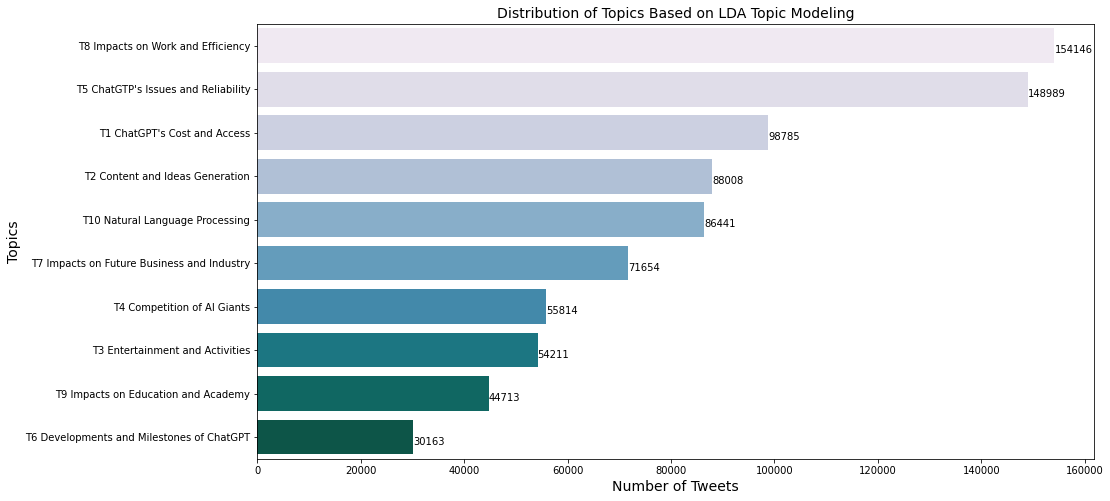

In [ ]:
#plot a bar chart to show the number of tweets for each topic
sort_name = topic_df.sort_values('Tweet_count',ascending=False)['Topic_Name'].to_list()
fig,ax = plt.subplots(1,1,figsize=(15,8))
ax = sns.barplot(y=topic_df['Topic_Name'], x=topic_df['Tweet_count'], order=sort_name, palette='PuBuGn')
for i in ax.patches:
    ax.annotate(int(i.get_width()), (i.get_width(), i.get_y()+0.5), va='center')
ax.set_ylabel('Topics', size=14)
ax.set_xlabel('Number of Tweets', size=14)
ax.set_title('Distribution of Topics Based on LDA Topic Modeling', size=14)

plt.show()

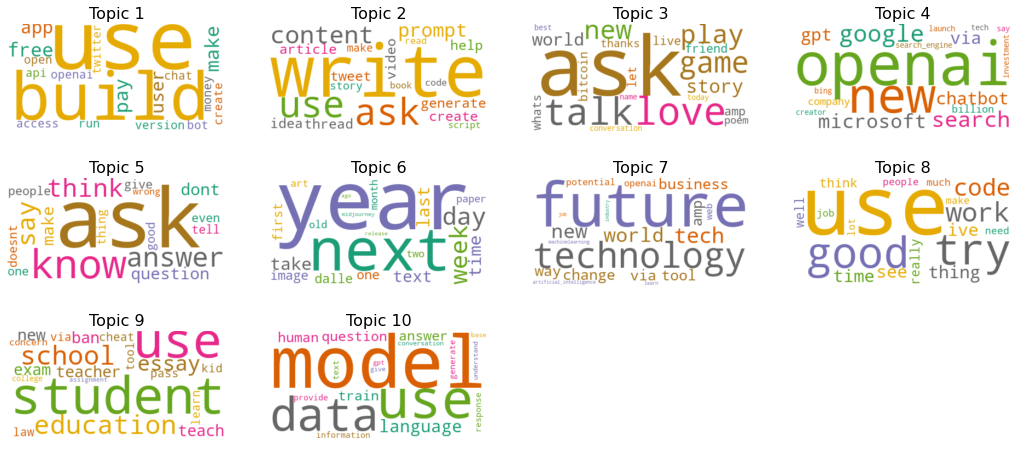

In [ ]:
# word cloud
from wordcloud import WordCloud
wc = WordCloud(background_color='white', colormap='Dark2', max_font_size=150, random_state=42)
fig, axs = plt.subplots(3,4, figsize=(18,8))
for i in range(12):
    plt.subplot(3,4,i+1)
    if i<10:
        wc.generate(topic_df['Topic_Terms'][i])
        plt.subplot(3,4,i+1)
        plt.imshow(wc, interpolation="bilinear")
        plt.title(topic_df.index[i], size=16)
    plt.axis('off')

plt.show()
